In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [16]:
with open("data/imagenet_labels.txt") as f:
    classes = eval(f.read())

In [17]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    #normalize the images with imagenet data mean and std
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [18]:
evalset = torchvision.datasets.ImageFolder(root = "data/imagenet", transform = transform)


In [19]:
batch_size=1 #batch size
evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle = True)

In [20]:
def imshow(img, title):
  
  """Custom function to display the image using matplotlib"""
  
  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.savefig('images/input.png',dpi=400)
  plt.show()

In [21]:
#custom function to fetch images from dataloader

def show_batch_images(dataloader):
  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model(images)
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred

In [22]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [23]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    plt.savefig("images/kernels.png",dpi=400)

In [33]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('images/kernels.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_weights(model,single_channel=True):
  
  #extracting the model features at the particular layer number
  layer = model.conv1
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.conv1.weight.data
    if single_channel:
      plot_filters_single_channel(weight_tensor)
    else:
      plot_filters_multi_channel(weight_tensor)

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


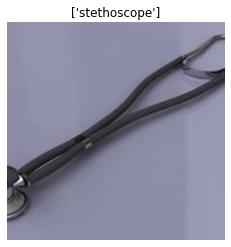

In [30]:
dataiter = iter(evalloader)
images, labels = dataiter.next()

#shape of images bunch
print(images.shape)
#shape of single image in a bunch
print(images[0].shape)

#label of the image
print(labels[0].item())
model = models.resnet18(pretrained=True)
model.eval()
images, pred = show_batch_images(evalloader)

torch.Size([1, 1000])


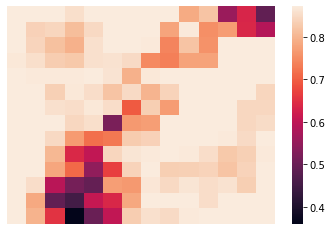

In [31]:
outputs = model(images)
print(outputs.shape)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

heatmap = occlusion(model, images, pred[0].item(), 32, 14)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    
figure.savefig('images/output.png', dpi=400)

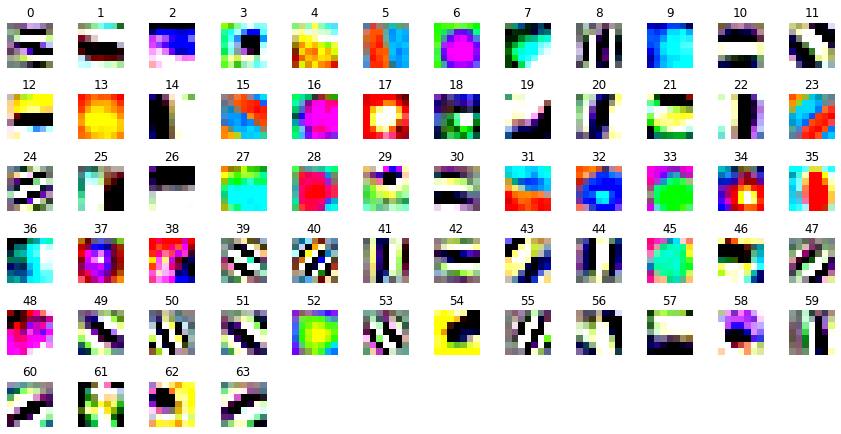

In [35]:
plot_weights(model,single_channel=False)

In [28]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  